Project Description:  People often tweet or post messages about events that happen close to them.
We are interested in tweets about natural disasters. We would like to be able to predict which texts actually mention real disasters. 


Our Data is pretty simple, it is an array of a tuples (id, keyword, location and text).
There is a train and test dataset, both weighing less than 1mb.
The train set also has a target column used for training.

Lets start setting up the project!


In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import re
from wordcloud import WordCloud

train = pd.read_csv(r"./train.csv")
test = pd.read_csv(r"./test.csv")

Lets do some EDA.

Lets check out the word count, visualize a wordcloud and the target distribution.

word count
7613


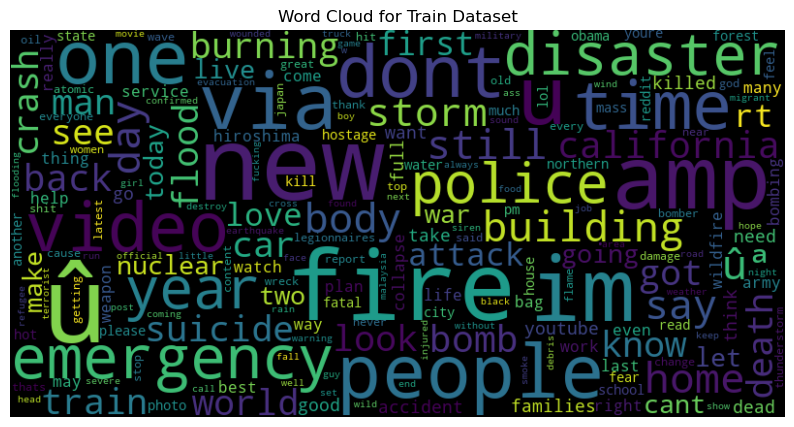

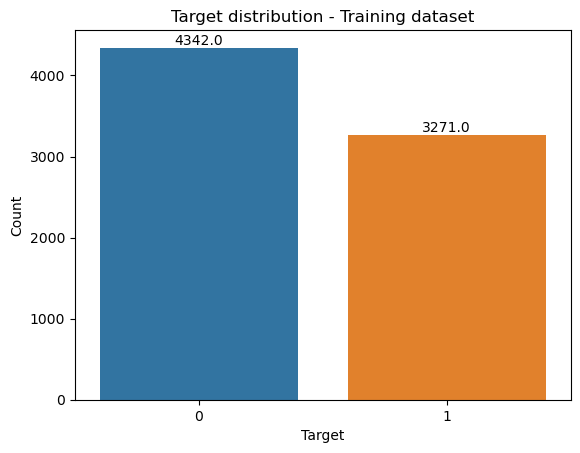

In [82]:
train.head()

train_text = ' '.join(train['text'].values)
print("word count")
print(len(train['text'].values))
wordcloud = WordCloud(width=800, height=400, max_font_size=110, collocations=False).generate(train_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Train Dataset')
plt.show()


sns.countplot(data=train, x='target')

ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f"{p.get_height()}", ha='center', va='bottom')

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target distribution - Training dataset')

plt.show()

Preparing and cleaning the data.
To clean the data we will take the most intuitive steps there are. Remove extra symbols and unnecessary characters and check for stopwords.

In [77]:
import string


nltk.download('stopwords')
from nltk.corpus import stopwords

def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'http\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newline characters
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

STOPWORDS = set(stopwords.words('english'))
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS]))
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gofma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now the fun part! Lets tokenize the words we have and create a LSTM model.

To note - a LSTM (Long Short-Term Memory) model is a type of recurrent neural network (RNN) architecture specifically designed to handle sequence prediction problems and time-series data. Unlike standard RNNs, LSTMs are capable of learning long-term dependencies, making them well-suited for tasks where context over time is important, such as language modeling, translation, and speech recognition.

Our model will have the following layers Embedding, SpatialDropout (Acts as a Regularization method and prevents overfitting) - prior to the LSTM and a dense layer for binary classification.

Epoch 1/5


c:\Users\gofma\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 3s - 31ms/step - accuracy: 0.6992 - loss: 0.5768 - val_accuracy: 0.7761 - val_loss: 0.4904
Epoch 2/5
96/96 - 1s - 9ms/step - accuracy: 0.8392 - loss: 0.3669 - val_accuracy: 0.7794 - val_loss: 0.4716
Epoch 3/5
96/96 - 1s - 9ms/step - accuracy: 0.8749 - loss: 0.2956 - val_accuracy: 0.7761 - val_loss: 0.5184
Epoch 4/5
96/96 - 1s - 9ms/step - accuracy: 0.8993 - loss: 0.2453 - val_accuracy: 0.7531 - val_loss: 0.5805
Epoch 5/5
96/96 - 1s - 8ms/step - accuracy: 0.9164 - loss: 0.2089 - val_accuracy: 0.7446 - val_loss: 0.6299


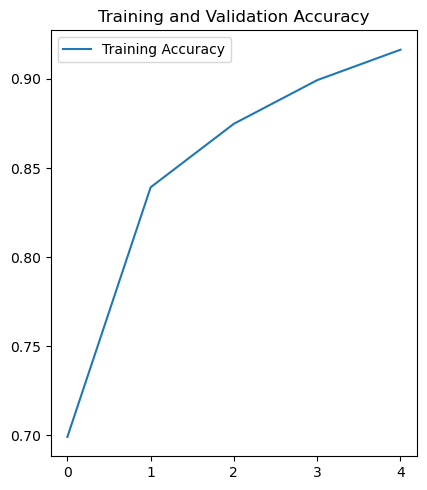

In [78]:

import numpy as np

import tensorflow

from tensorflow import keras

from keras import datasets, layers, models, preprocessing, utils, optimizers



from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Tokenize the text
tokenizer = keras.preprocessing.text.Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(train['text'].values)
# Tokenize the text

X_train = tokenizer.texts_to_sequences(train['text'].values)
X_train = utils.pad_sequences(X_train)

X_test = tokenizer.texts_to_sequences(test['text'].values)
X_test = utils.pad_sequences(X_test, maxlen=X_train.shape[1])

# Encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train['target'])

# Convert labels to categorical one-hot encoding
y_train = utils.to_categorical(y_train, num_classes=2)
# Build the model
model = models.Sequential()

model.add(layers.Embedding(input_dim=5000, output_dim=128, input_length=X_train.shape[1]))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 64
modelhistory = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_split=0.2, verbose=2)

acc = modelhistory.history['accuracy']

epochs = range(len(acc))

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training Accuracy')

plt.title('Training and Validation Accuracy')
plt.legend()



plt.tight_layout()
plt.show()



Of course, no assignment would be complete without some parameter hypertuning. Lets use a hyperband tuner and run it on our model.

Reloading Tuner from my_dir\hyperparameter_tuning\tuner0.json
Epoch 1/5


c:\Users\gofma\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 3s - 36ms/step - accuracy: 0.6718 - loss: 0.6091 - val_accuracy: 0.7708 - val_loss: 0.4999
Epoch 2/5
96/96 - 1s - 9ms/step - accuracy: 0.8305 - loss: 0.4018 - val_accuracy: 0.7768 - val_loss: 0.4741
Epoch 3/5
96/96 - 1s - 9ms/step - accuracy: 0.8622 - loss: 0.3325 - val_accuracy: 0.7873 - val_loss: 0.4833
Epoch 4/5
96/96 - 1s - 9ms/step - accuracy: 0.8816 - loss: 0.2910 - val_accuracy: 0.7643 - val_loss: 0.5119
Epoch 5/5
96/96 - 1s - 9ms/step - accuracy: 0.8995 - loss: 0.2522 - val_accuracy: 0.7525 - val_loss: 0.5818
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


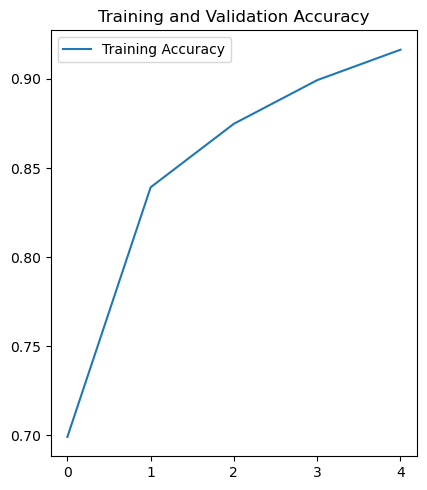

In [79]:
# Tokenizer should be created and fitted before this step
# X_train preparation


import keras_tuner as kt

X_train = tokenizer.texts_to_sequences(train['text'].values)
X_train = utils.pad_sequences(X_train)

# X_test preparation
X_train = tokenizer.texts_to_sequences(train['text'].values)
X_train = utils.pad_sequences(X_train)

X_test = tokenizer.texts_to_sequences(test['text'].values)
X_test = utils.pad_sequences(X_test, maxlen=X_train.shape[1])

# Encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train['target'])

# Convert labels to categorical one-hot encoding
y_train = utils.to_categorical(y_train, num_classes=2)

# Define the model building function
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=5000,
                               output_dim=hp.Int('embedding_dim', min_value=64, max_value=256, step=64),
                               input_length=X_train.shape[1]))
    model.add(layers.SpatialDropout1D(hp.Float('spatial_dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(layers.LSTM(units=hp.Int('lstm_units', min_value=50, max_value=200, step=50),
                          dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1),
                          recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='hyperparameter_tuning')

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = build_model(best_hps)
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=2)

# Predict on the test data
predictions = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

acc = modelhistory.history['accuracy']

epochs = range(len(acc))

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training Accuracy')

plt.title('Training and Validation Accuracy')
plt.legend()



plt.tight_layout()
plt.show()

In [80]:
# Train the model
batch_size = 64
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_split=0.2, verbose=2)

# Obtain predictions for the test set
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Optionally, map predicted classes back to original labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Create a DataFrame with the predictions
output = pd.DataFrame({'id': test['id'], 'target': predicted_labels})

# Save the predictions to a CSV file
output.to_csv('submission.csv', index=False)

Epoch 1/5
96/96 - 1s - 10ms/step - accuracy: 0.9100 - loss: 0.2252 - val_accuracy: 0.7505 - val_loss: 0.6108
Epoch 2/5
96/96 - 1s - 9ms/step - accuracy: 0.9225 - loss: 0.2034 - val_accuracy: 0.7347 - val_loss: 0.6997
Epoch 3/5
96/96 - 1s - 9ms/step - accuracy: 0.9281 - loss: 0.1830 - val_accuracy: 0.7597 - val_loss: 0.7220
Epoch 4/5
96/96 - 1s - 9ms/step - accuracy: 0.9355 - loss: 0.1643 - val_accuracy: 0.7406 - val_loss: 0.7635
Epoch 5/5
96/96 - 1s - 9ms/step - accuracy: 0.9447 - loss: 0.1468 - val_accuracy: 0.7406 - val_loss: 0.7997
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


As we can see when looking on our accurasy reports - we've achieved great results. 
I can't say that there were issues during the course of this project, however I am slightly dissapointed that the hyperparameter tuning did not have a major effect on accuracy.

Given more time i would try to increase the number of additional layers in the model to further better the results.